# 고양이 수염 스티커만들기
## (Camera_Sticker)  
  
***
### Step1. 이미지 준비하기

In [23]:
# 라이브러리 import
import cv2 # 이미지 처리를 위한 라이브러리
import matplotlib.pyplot as plt # 이미지 출력을 위한 라이브러리
import numpy as np 
print("라이브러리 import완료!")

라이브러리 import완료!


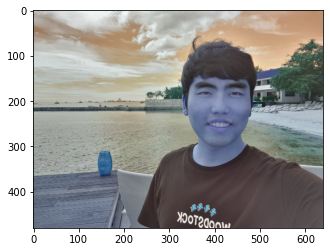

In [24]:
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

plt.imshow(img_bgr)
plt.show()

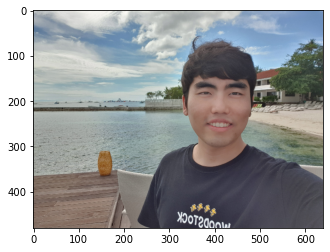

In [25]:
# opencv는 이미지채널을 RGB가 아닌 BGR을 사용하기때문에 푸르게 보임.
# 따라서 cv2.cvtcolor(이미지경로, cv2.COLOR_BGR2RGB)를 사용하여야함.
# BGR채널을 RGB로 변경.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### Step2. 얼굴 검출 & 랜드마크 검출하기

In [26]:
# 얼굴 검출을 위한 라이브러리 import
import dlib
detector_hog = dlib.get_frontal_face_detector() # 얼굴 검출기 선언
print("검출기 선언 완료!")

검출기 선언 완료!


In [27]:
# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1) # 찾은 얼굴영역의 좌표
print(dlib_rects)
print("bounding box 추출 완료!")

rectangles[[(339, 133) (494, 288)]]
bounding box 추출 완료!


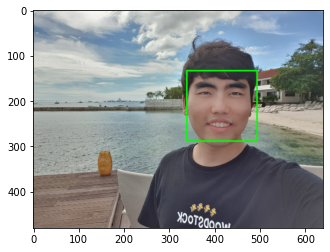

In [28]:
# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [29]:
# landmark 모델 불러오기
import os
# 모델의 위치주소
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("랜드마크 모델 불러오기 완료!")

랜드마크 모델 불러오기 완료!


In [30]:
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))


68


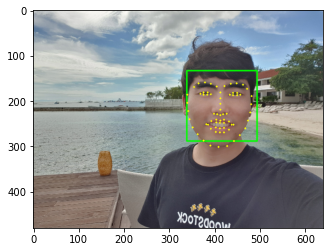

In [31]:
# 랜드마크 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Step 3. 스티커 적용 위치 확인하기

In [32]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[1]) 
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width() # 스티커의 넓이
    h = dlib_rect.width() # 스티커의 높이
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(340, 204)
(x,y) : (413,219)
(w,h) : (156,156)


In [33]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

# 스티커 형상 확인
# img_sticker_re = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
# plt.imshow(img_sticker_re)
# plt.show()

(156, 156, 3)


In [34]:
x = x - img_sticker.shape[1]//2     # left
y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
print ('(x,y) : (%d,%d)'%(x, y))

(x,y) : (335,141)


In [35]:
# 스티커 적용위치 확인
sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

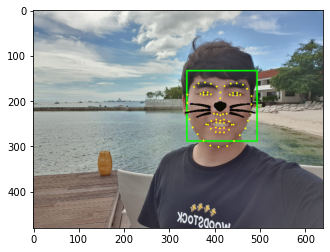

In [36]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 4. 스티커 적용하기

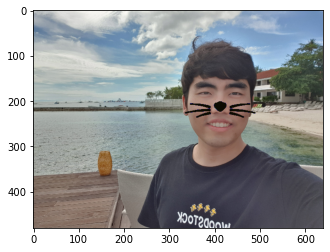

In [37]:
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### Step 5. 변수에 따른 스티커적용
***
- 기본사진적용(레이첼 맥아담스)

(224, 224, 3)


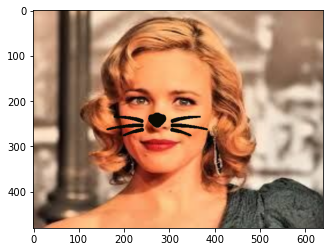

In [38]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel0.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# plt.imshow(img_show_rgb)
# plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))   
    
x = x - img_sticker.shape[1]//2     # left
y = y - img_sticker.shape[0]//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


- 정면 얼굴의 경우 랜드마크를 잘 인식하여 스티커를 원하는 위치에 잘 붙였다.
***
- 얼굴의 각도 변형(레이첼 맥아담스)

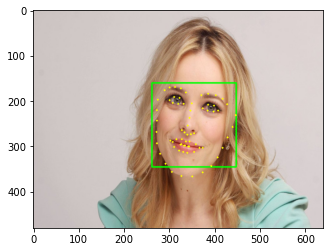

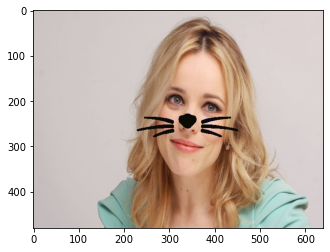

In [40]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel1.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat3.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = img_sticker.shape[1]
    h = img_sticker.shape[0]
    
x = x - w//2     # left
y = y - h//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


- 얼굴의 각도가 변형된 경우에는 스티커의 위치는 맞았으나, 각도의 변형이 필요하였다.
***
- 얼굴의 각도 변형_옆얼굴(레이첼 맥아담스)

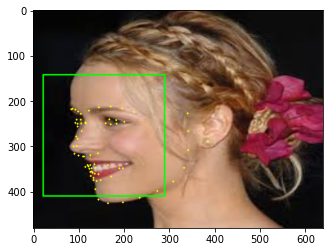

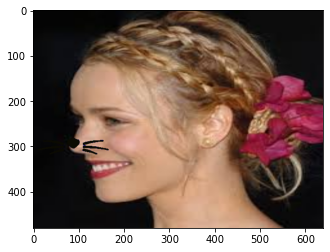

In [1073]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel2.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = img_sticker.shape[1]
    h = img_sticker.shape[0]
    
x = x - w//2     # left
y = y - h//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


- 옆에서 찍은 사진 또한 각도에 따른 변화 및 색 변화가 필요해보였다.
***
- 

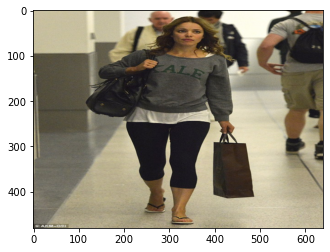

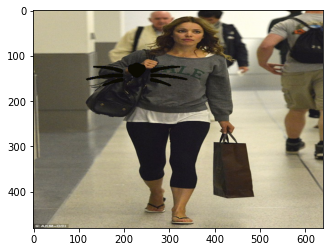

In [41]:
# 이미지 준비
# 준비한 이미지 읽어오기
import os # 이미지의 경로를 설정하기 위한 os모듈 라이브러리
# 이미지의 경로 설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/rachel3.jpg'
# cv2를 이용하여 이미지 불러오기
# .imread(이미지경로,이미지옵션)
# 이미지옵션(1: 기본옵션, 0: 흑백(gray scale), -1: alpha channel포함)
img_bgr = cv2.imread(my_image_path)

img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

# 얼굴 검출 & 랜드마크 검출하기
detector_hog = dlib.get_frontal_face_detector()

# dlib가 RPG이미지를 입력으로 받기때문에 cv2.cvtColor()를 통해 BGR이미지를 RGB로 변환.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# detector_hog(이미지, 이미지 피라미드 갯수)
dlib_rects = detector_hog(img_rgb,1)

# 얼굴영역 좌표에따른 사각형을 화면에 출력하기
# 얼굴영역의 위취정보를 각각 l, t, r, b에 넣기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 이미지 img_show에 l,t,r,b점을 이용해서 녹색으로 사각형 그리기
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

# 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 위치 리스트에 정리
list_landmarks = []
for dlib_rect in dlib_rects: # dlib_rects = detector_hog(img_rgb,1)
    points = landmark_predictor(img_rgb, dlib_rect)    
    list_points = list(map(lambda p: (p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 스티커 적용 위치 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # nose center index : 30
    # 스티커의 시작위치는 스티커 박스의 왼쪽 상부 모서리이다.
    x = landmark[30][0]
    y = landmark[30][1]
    w = img_sticker.shape[1]
    h = img_sticker.shape[0]
    
x = x - w//2     # left
y = y - h//2     # top
# 코 중심에서부터 시작했기 때문에 스티커 박스의 중심이 코 중심이 되도록 움직여준다.
    
#스티커 적용하기
sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
# np.where(조건, 참일경우, 아닐경우)
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()
